# Setup

Navigate to the project's root directory:

In [1]:
%cd ..

/opt/rossmann-tf


In [2]:
%matplotlib inline

# Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# Data

In [4]:
train_df = pd.read_parquet('./data/train_clean.parquet')
test_df = pd.read_parquet('./data/test_clean.parquet')

In [5]:
train_df.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,...,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,0,1,5,2015-07-31,5263,555,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,7.0,0.0,5.0
1,1,2,5,2015-07-31,6064,625,1,1,False,1,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
2,2,3,5,2015-07-31,8314,821,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,5.0,0.0,5.0
3,3,4,5,2015-07-31,13995,1498,1,1,False,1,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
4,4,5,5,2015-07-31,4822,559,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0


In [6]:
test_df.head()

,index,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,...,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,0,1,1,4,2015-09-17,1.0,1,False,0,2015,...,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,1,2,3,4,2015-09-17,1.0,1,False,0,2015,...,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
2,2,3,7,4,2015-09-17,1.0,1,False,0,2015,...,115,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
3,3,4,8,4,2015-09-17,1.0,1,False,0,2015,...,115,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
4,4,5,9,4,2015-09-17,1.0,1,False,0,2015,...,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0


# Column Names

Check column names that are in `train_df` but not in `test_df`:

In [7]:
set(train_df.columns).difference(set(test_df.columns))

{'Customers', 'Sales'}

What is in `test_df` but not in `train_df`?

In [8]:
set(test_df.columns).difference(set(train_df.columns))

{'Id'}

I guess if you knew the number of customers then you could give a good approximation of the sales...

Note that `Sales` is the variable you are trying to predict.

## Summary statistics

In [9]:
train_df.shape

(844338, 93)

In [10]:
test_df.shape

(41088, 92)

# Feature types

Create lists to isolate the continuous and categorical variable:

In [11]:
# from https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson6-rossmann.ipynb
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

target = ['Sales']

In [12]:
# my modifications
# based on https://en.wikipedia.org/wiki/Okta, CloudCover is categorical
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw', 'Promo', 'SchoolHoliday', 'CloudCover']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday']

target = ['Sales']

cat_vars = sorted(cat_vars)
cont_vars = sorted(cont_vars)

What are the variables not used as features?

In [13]:
set(train_df.columns).difference(set(cat_vars + cont_vars + target))

{'AfterPromo',
 'AfterSchoolHoliday',
 'BeforePromo',
 'BeforeSchoolHoliday',
 'CompetitionDaysOpen',
 'CompetitionOpenSince',
 'CompetitionOpenSinceMonth',
 'Customers',
 'Date',
 'Date_DE',
 'Day_DE',
 'Dayofweek',
 'Dayofweek_DE',
 'Dayofyear',
 'Dayofyear_DE',
 'Dew_PointC',
 'Elapsed',
 'Elapsed_DE',
 'Is_month_end',
 'Is_month_end_DE',
 'Is_month_start',
 'Is_month_start_DE',
 'Is_quarter_end',
 'Is_quarter_end_DE',
 'Is_quarter_start',
 'Is_quarter_start_DE',
 'Is_year_end',
 'Is_year_end_DE',
 'Is_year_start',
 'Is_year_start_DE',
 'Max_Gust_SpeedKm_h',
 'Max_Sea_Level_PressurehPa',
 'Max_VisibilityKm',
 'MeanDew_PointC',
 'Mean_Sea_Level_PressurehPa',
 'Mean_VisibilityKm',
 'Min_DewpointC',
 'Min_Sea_Level_PressurehPa',
 'Min_VisibilitykM',
 'Month_DE',
 'Open',
 'Precipitationmm',
 'Promo2',
 'Promo2Days',
 'Promo2Since',
 'Promo2SinceWeek',
 'StateName',
 'State_DE',
 'WindDirDegrees',
 'file',
 'file_DE',
 'index',
 'week',
 'week_DE'}

## Continuous variables

Are there missing values in the continuous variables?

In [14]:
train_df[cont_vars].isna().sum()

AfterStateHoliday         0
BeforeStateHoliday        0
CompetitionDistance    2186
Max_Humidity              0
Max_TemperatureC          0
Max_Wind_SpeedKm_h        0
Mean_Humidity             0
Mean_TemperatureC         0
Mean_Wind_SpeedKm_h       0
Min_Humidity              0
Min_TemperatureC          0
trend                     0
trend_DE                  0
dtype: int64

In [15]:
test_df[cont_vars].isna().sum()

AfterStateHoliday       0
BeforeStateHoliday      0
CompetitionDistance    96
Max_Humidity            0
Max_TemperatureC        0
Max_Wind_SpeedKm_h      0
Mean_Humidity           0
Mean_TemperatureC       0
Mean_Wind_SpeedKm_h     0
Min_Humidity            0
Min_TemperatureC        0
trend                   0
trend_DE                0
dtype: int64

Following Jeremy Howard's [approach](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson6-rossmann.ipynb), we will replace the missing `CompetitionDistance` with the median and create a boolean variable to indicate that it is missing:

In [16]:
median_dist = train_df['CompetitionDistance'].median()

train_df['CompetitionDistance_na'] = train_df['CompetitionDistance'].isna()
train_df['CompetitionDistance'] = np.where(train_df['CompetitionDistance'].isna(), 
                                           median_dist, 
                                           train_df['CompetitionDistance'])

test_df['CompetitionDistance_na'] = test_df['CompetitionDistance'].isna()
test_df['CompetitionDistance'] = np.where(test_df['CompetitionDistance'].isna(), 
                                          median_dist, 
                                          test_df['CompetitionDistance'])

# treat the missing competition distance column as categorical
cat_vars = cat_vars + ['CompetitionDistance_na']

View the distribution of the continuous variables:

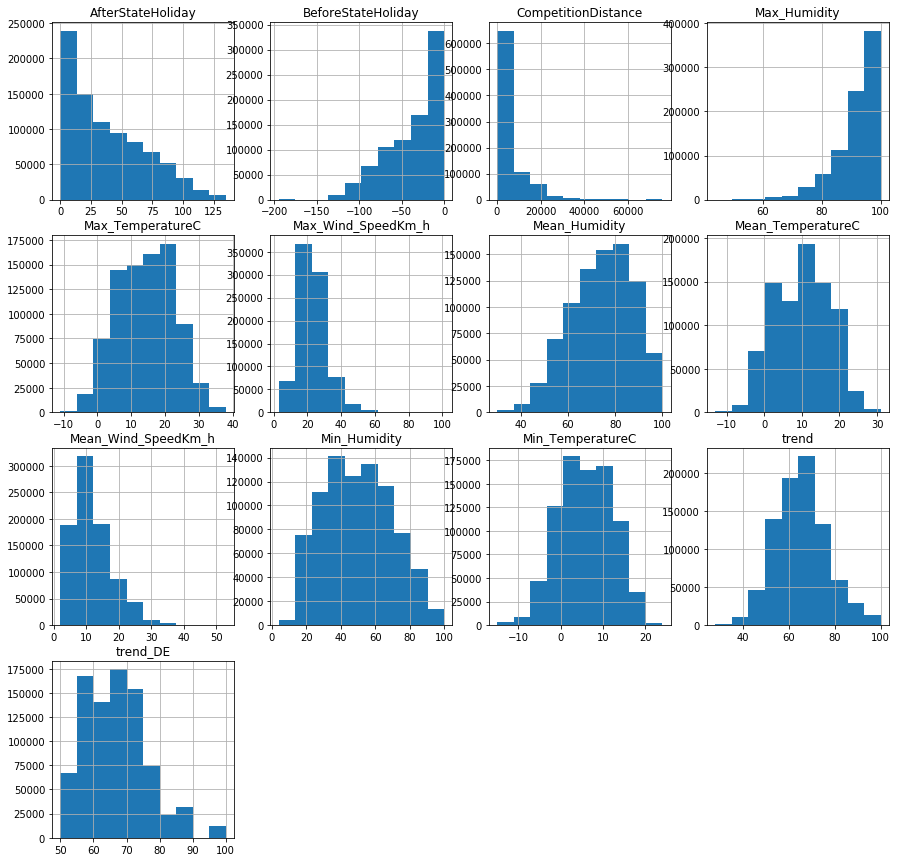

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15))
axes[-1][-1].axis('off')
axes[-1][-2].axis('off')
axes[-1][-3].axis('off')

for i in range(4):
    for j in range(4):
        idx = i*4 + j
        if idx > len(cont_vars) - 1:
            break
        var = cont_vars[i*4 + j]
        
        train_df[var].hist(ax=axes[i,j])
        axes[i,j].set_title(var)

Create list of variables to do log scaling:

In [18]:
log_scale_vars = ['CompetitionDistance', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h']

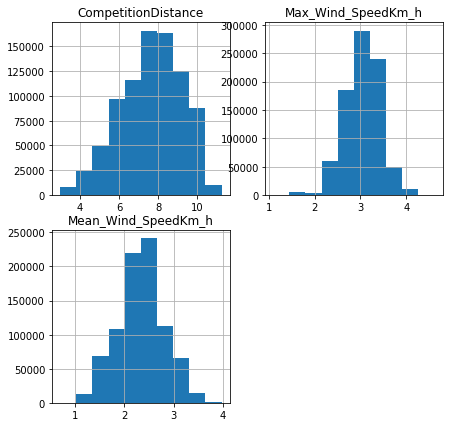

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7,7))
axes[-1][-1].axis('off')

for i in range(2):
    for j in range(2):
        idx = i*2 + j
        if idx > len(log_scale_vars) - 1:
            break
        var = log_scale_vars[i*2 + j]
        
        train_df[var].apply(lambda val: np.log(val+1/1000)).hist(ax=axes[i,j])
        axes[i,j].set_title(var)

Create list of variables to do quantile bucketing and figure out the bin widths:

In [20]:
quantile_buckets = ['AfterStateHoliday', 'BeforeStateHoliday', 'Max_Humidity']
n_quantiles = [10, 10, 2]

In [21]:
for col, n in zip(quantile_buckets, n_quantiles):
    print('Buckets for {}:'.format(col))
    
    est = KBinsDiscretizer(n_bins=n, encode='ordinal', strategy='quantile')
    bucket_name = col + '_bucket'
    cat_vars = cat_vars + [bucket_name]
    
    train_vals = train_df[col].values.reshape(-1,1)
    train_df[bucket_name] = est.fit_transform(train_vals).reshape(-1)
    
    test_vals = test_df[col].values.reshape(-1, 1)
    test_df[bucket_name] = est.transform(test_vals).reshape(-1)
    
    results = train_df[bucket_name].value_counts()
    n_buckets, = results.shape
    
    print('Total buckets: {}'.format(n_buckets))
    print('Bin edges: {}'.format(est.bin_edges_))
    print(results)
    print('Total observations: {}'.format(results.sum()))
    print('\n')
    

Buckets for AfterStateHoliday:
Total buckets: 10
Bin edges: [array([  0.,   4.,   8.,  15.,  22.,  30.,  42.,  53.,  68.,  84., 135.])]
2.0    100039
7.0     88771
9.0     88233
5.0     87381
4.0     85110
1.0     85109
8.0     81476
3.0     81039
6.0     80103
0.0     67077
Name: AfterStateHoliday_bucket, dtype: int64
Total observations: 844338


Buckets for BeforeStateHoliday:
Total buckets: 10
Bin edges: [array([-195.,  -85.,  -68.,  -52.,  -39.,  -28.,  -20.,  -11.,   -6.,
         -2.,    0.])]
9.0    98344
6.0    94996
1.0    87815
3.0    85653
2.0    83740
5.0    82477
7.0    82262
0.0    79848
4.0    75311
8.0    73892
Name: BeforeStateHoliday_bucket, dtype: int64
Total observations: 844338


Buckets for Max_Humidity:
Total buckets: 2
Bin edges: [array([ 44.,  94., 100.])]
1.0    501606
0.0    342732
Name: Max_Humidity_bucket, dtype: int64
Total observations: 844338




What would z-scoring the continuous variables look like?

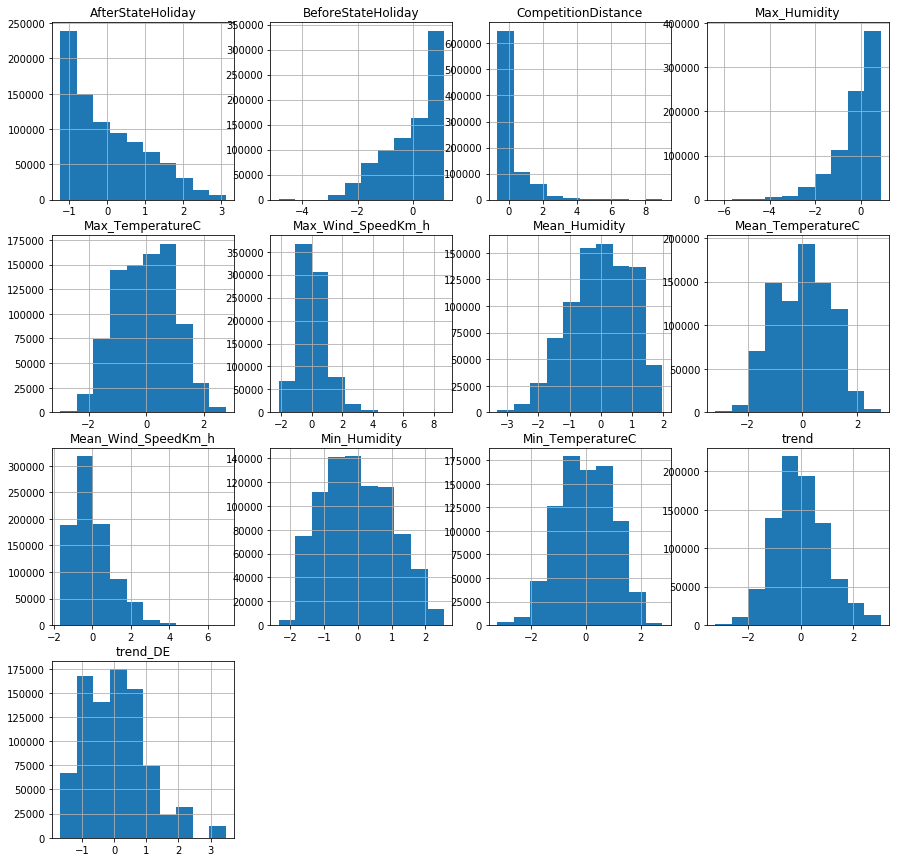

In [22]:
z_score_train_df = (train_df[cont_vars] - train_df[cont_vars].mean())/train_df[cont_vars].std(ddof=0)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15))
axes[-1][-1].axis('off')
axes[-1][-2].axis('off')
axes[-1][-3].axis('off')

for i in range(4):
    for j in range(4):
        idx = i*4 + j
        if idx > len(cont_vars) - 1:
            break
        var = cont_vars[i*4 + j]
        
        z_score_train_df[var].hist(ax=axes[i,j])
        axes[i,j].set_title(var)

## Categorical variables

Set `CloudCover` to a string:

In [23]:
train_df['CloudCover'] = train_df['CloudCover'].astype(np.str)
test_df['CloudCover'] = test_df['CloudCover'].astype(np.str)

Check for missing values in the categorical variables:

In [24]:
train_df[cat_vars].isna().sum()

Assortment                        0
CloudCover                        0
CompetitionMonthsOpen             0
CompetitionOpenSinceYear          0
Day                               0
DayOfWeek                         0
Events                       203057
Month                             0
Promo                             0
Promo2SinceYear                   0
Promo2Weeks                       0
PromoInterval                423292
Promo_bw                          0
Promo_fw                          0
SchoolHoliday                     0
SchoolHoliday_bw                  0
SchoolHoliday_fw                  0
State                             0
StateHoliday                      0
StateHoliday_bw                   0
StateHoliday_fw                   0
Store                             0
StoreType                         0
Week                              0
Year                              0
CompetitionDistance_na            0
AfterStateHoliday_bucket          0
BeforeStateHoliday_bucket   

In [25]:
test_df[cat_vars].isna().sum()

Assortment                       0
CloudCover                       0
CompetitionMonthsOpen            0
CompetitionOpenSinceYear         0
Day                              0
DayOfWeek                        0
Events                       10155
Month                            0
Promo                            0
Promo2SinceYear                  0
Promo2Weeks                      0
PromoInterval                17232
Promo_bw                         0
Promo_fw                         0
SchoolHoliday                    0
SchoolHoliday_bw                 0
SchoolHoliday_fw                 0
State                            0
StateHoliday                     0
StateHoliday_bw                  0
StateHoliday_fw                  0
Store                            0
StoreType                        0
Week                             0
Year                             0
CompetitionDistance_na           0
AfterStateHoliday_bucket         0
BeforeStateHoliday_bucket        0
Max_Humidity_bucket 

In [26]:
train_df[cat_vars].dtypes

Assortment                    object
CloudCover                    object
CompetitionMonthsOpen          int64
CompetitionOpenSinceYear       int32
Day                            int64
DayOfWeek                      int64
Events                        object
Month                          int64
Promo                          int64
Promo2SinceYear                int32
Promo2Weeks                    int64
PromoInterval                 object
Promo_bw                     float64
Promo_fw                     float64
SchoolHoliday                  int64
SchoolHoliday_bw             float64
SchoolHoliday_fw             float64
State                         object
StateHoliday                    bool
StateHoliday_bw              float64
StateHoliday_fw              float64
Store                          int64
StoreType                     object
Week                           int64
Year                           int64
CompetitionDistance_na          bool
AfterStateHoliday_bucket     float64
B

Fill missing categorical variables with '-1' (these are string columns):

In [27]:
train_df[cat_vars] = train_df[cat_vars].fillna('-1')
test_df[cat_vars] = test_df[cat_vars].fillna('-1')

Convert the float columns into integers:

In [28]:
float_columns = train_df[cat_vars]\
    .dtypes.where(lambda val: val == np.float64)\
    .dropna()\
    .index\
    .tolist()

for column in float_columns:
    train_df[column] = train_df[column].astype(np.int32)
    test_df[column] = train_df[column].astype(np.int32)

In [29]:
train_df[cat_vars].dtypes

Assortment                   object
CloudCover                   object
CompetitionMonthsOpen         int64
CompetitionOpenSinceYear      int32
Day                           int64
DayOfWeek                     int64
Events                       object
Month                         int64
Promo                         int64
Promo2SinceYear               int32
Promo2Weeks                   int64
PromoInterval                object
Promo_bw                      int32
Promo_fw                      int32
SchoolHoliday                 int64
SchoolHoliday_bw              int32
SchoolHoliday_fw              int32
State                        object
StateHoliday                   bool
StateHoliday_bw               int32
StateHoliday_fw               int32
Store                         int64
StoreType                    object
Week                          int64
Year                          int64
CompetitionDistance_na         bool
AfterStateHoliday_bucket      int32
BeforeStateHoliday_bucket   

In [30]:
test_df[cat_vars].dtypes

Assortment                   object
CloudCover                   object
CompetitionMonthsOpen         int64
CompetitionOpenSinceYear      int32
Day                           int64
DayOfWeek                     int64
Events                       object
Month                         int64
Promo                         int64
Promo2SinceYear               int32
Promo2Weeks                   int64
PromoInterval                object
Promo_bw                      int32
Promo_fw                      int32
SchoolHoliday                 int64
SchoolHoliday_bw              int32
SchoolHoliday_fw              int32
State                        object
StateHoliday                   bool
StateHoliday_bw               int32
StateHoliday_fw               int32
Store                         int64
StoreType                    object
Week                          int64
Year                          int64
CompetitionDistance_na         bool
AfterStateHoliday_bucket      int32
BeforeStateHoliday_bucket   

Get the vocabulary for the object columns:

In [31]:
obj_columns = train_df[cat_vars]\
    .dtypes.where(lambda val: val == np.object)\
    .dropna()\
    .index\
    .tolist()

for column in obj_columns:
    print('vocab for {}:'.format(column))
    print(train_df[column].unique())
    print('\n')

vocab for Assortment:
['a' 'c' 'b']


vocab for CloudCover:
['1.0' '4.0' '2.0' '6.0' '5.0' 'nan' '3.0' '8.0' '7.0' '0.0']


vocab for Events:
['Fog' '-1' 'Rain' 'Rain-Thunderstorm' 'Fog-Rain' 'Rain-Hail-Thunderstorm'
 'Fog-Rain-Thunderstorm' 'Thunderstorm' 'Rain-Hail' 'Fog-Thunderstorm'
 'Rain-Snow' 'Fog-Rain-Hail-Thunderstorm' 'Snow' 'Rain-Snow-Hail'
 'Rain-Snow-Hail-Thunderstorm' 'Rain-Snow-Thunderstorm' 'Fog-Rain-Snow'
 'Fog-Snow' 'Snow-Hail' 'Fog-Rain-Snow-Hail' 'Fog-Rain-Hail'
 'Fog-Snow-Hail']


vocab for PromoInterval:
['-1' 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


vocab for State:
['HE' 'TH' 'NW' 'BE' 'SN' 'SH' 'HB,NI' 'BY' 'BW' 'RP' 'ST' 'HH']


vocab for StoreType:
['c' 'a' 'd' 'b']




Check that test set has no new vocabulary:

In [32]:
for column in obj_columns:
    train_vocab = train_df[column].unique()
    test_vocab = test_df[column].unique()
    
    assert all([vocab in train_vocab for vocab in test_vocab])

# Target Variable

`Sales` is a float, not an integer:

In [33]:
train_df['Sales'] = train_df['Sales'].astype(np.float)

# Save

Save all edits to train and test sets to a new parquet file:

In [34]:
# you need date to split into train and validation set
train_cols = ['Date'] + cont_vars + cat_vars + ['Sales']
# you need Id to make submission to kaggle later
test_cols = ['Id'] + cont_vars + cat_vars

In [35]:
train_df[train_cols].to_parquet('./data/train_model_features.parquet', index=False)
test_df[test_cols].to_parquet('./data/test_model_features.parquet', index=False)

Print the updated list of continous and categorical variables for reference:

In [36]:
cont_vars

['AfterStateHoliday',
 'BeforeStateHoliday',
 'CompetitionDistance',
 'Max_Humidity',
 'Max_TemperatureC',
 'Max_Wind_SpeedKm_h',
 'Mean_Humidity',
 'Mean_TemperatureC',
 'Mean_Wind_SpeedKm_h',
 'Min_Humidity',
 'Min_TemperatureC',
 'trend',
 'trend_DE']

In [37]:
cat_vars

['Assortment',
 'CloudCover',
 'CompetitionMonthsOpen',
 'CompetitionOpenSinceYear',
 'Day',
 'DayOfWeek',
 'Events',
 'Month',
 'Promo',
 'Promo2SinceYear',
 'Promo2Weeks',
 'PromoInterval',
 'Promo_bw',
 'Promo_fw',
 'SchoolHoliday',
 'SchoolHoliday_bw',
 'SchoolHoliday_fw',
 'State',
 'StateHoliday',
 'StateHoliday_bw',
 'StateHoliday_fw',
 'Store',
 'StoreType',
 'Week',
 'Year',
 'CompetitionDistance_na',
 'AfterStateHoliday_bucket',
 'BeforeStateHoliday_bucket',
 'Max_Humidity_bucket']